In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

In [2]:
class CNN_Mnist(nn.Module):
    def __init__(self):
        super(CNN_Mnist, self).__init__()

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            nn.ReLU()
        )

        self.mu = nn.Sequential(
            nn.Linear(512, 3)
        )

        self.var = nn.Sequential(
            nn.Linear(512, 3)
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Unflatten(1, (1, 28, 28)),
            nn.Sigmoid()
        )


    def forward(self, x):
        enc = self.encoder(x)
        mu, lv = self.mu(enc), self.var(enc)
        rec_lat = self.reparam(mu, lv)
        dec = self.decoder(rec_lat)
        
        return dec, mu, lv

    def reparam(self, mu, lv):
        std = torch.exp(0.5 * lv)
        eps = torch.randn(lv.size()).to(lv.device)
        return mu + std * eps

In [3]:
def gaussian_kls(mu, logvar, mean=False):

    klds = -0.5*(1 + logvar - mu.pow(2) - logvar.exp())

    if mean:
        reduce = lambda x: torch.mean(x, 1)
    else:
        reduce = lambda x: torch.sum(x, 1)

    total_kld = reduce(klds).mean(0, True)
    dimension_wise_kld = klds.mean(0)
    mean_kld = reduce(klds).mean(0, True)

    return total_kld, dimension_wise_kld, mean_kld

In [4]:
transform = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)

trainset = MNIST(root='~/data', train=True, download=True, transform=transform)
train_dl = DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2)
testset = MNIST(root='~/data', train=False, download=True, transform=transform)
test_dl = DataLoader(testset, batch_size=256, shuffle=False, num_workers=2)

print(len(train_dl), len(test_dl))

235 40


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = CNN_Mnist().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.0001)

loss_fn = nn.BCELoss()

In [6]:
for epoch in range(60):
    model.train()
    tr_total_loss = 0
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img, train_mu, train_lv = model(train_img)
        train_rec_loss = loss_fn(gen_img, train_img)
        train_kl_loss, _, _ = gaussian_kls(train_mu, train_lv)
        train_loss = train_rec_loss + train_kl_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        tr_total_loss += train_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        for valid_img, _ in tqdm(test_dl):
            valid_img = valid_img.to(device)

            gen_img, valid_mu, valid_lv = model(valid_img)
            valid_rec_loss = loss_fn(gen_img, valid_img)
            valid_kl_loss, _, _ = gaussian_kls(valid_mu, valid_lv)
            valid_loss = valid_rec_loss + valid_kl_loss

            va_total_loss += valid_loss.item()

    print(f"Epoch: {epoch} - TrainLoss: {tr_total_loss/len(train_dl)} - ValidLoss: {va_total_loss/len(test_dl)}")

100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 79.41it/s]


Epoch: 0 - TrainLoss: 0.42357154856336876 - ValidLoss: 0.3148788146674633


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 81.24it/s]


Epoch: 1 - TrainLoss: 0.294038461370671 - ValidLoss: 0.2817363016307354


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 80.47it/s]


Epoch: 2 - TrainLoss: 0.2765602252584823 - ValidLoss: 0.2727001465857029


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 79.92it/s]


Epoch: 3 - TrainLoss: 0.2707807703221098 - ValidLoss: 0.26902506351470945


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 81.26it/s]


Epoch: 4 - TrainLoss: 0.26804801580753734 - ValidLoss: 0.26701763942837714


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 81.99it/s]


Epoch: 5 - TrainLoss: 0.2665159534900746 - ValidLoss: 0.265977393835783


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 84.46it/s]


Epoch: 6 - TrainLoss: 0.2656305639033622 - ValidLoss: 0.2650821290910244


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 75.85it/s]


Epoch: 7 - TrainLoss: 0.26501090234898506 - ValidLoss: 0.2645939916372299


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 79.09it/s]


Epoch: 8 - TrainLoss: 0.2645124696670695 - ValidLoss: 0.26431149765849116


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 80.07it/s]


Epoch: 9 - TrainLoss: 0.26417520477416667 - ValidLoss: 0.26388867720961573


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 83.12it/s]


Epoch: 10 - TrainLoss: 0.2639709144196612 - ValidLoss: 0.2637448862195015


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 82.35it/s]


Epoch: 11 - TrainLoss: 0.2637930102804874 - ValidLoss: 0.26357987970113755


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 82.23it/s]


Epoch: 12 - TrainLoss: 0.26365141576909007 - ValidLoss: 0.2634345628321171


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 80.07it/s]


Epoch: 13 - TrainLoss: 0.26353093740787914 - ValidLoss: 0.2633483223617077


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 83.43it/s]


Epoch: 14 - TrainLoss: 0.2634296802764243 - ValidLoss: 0.26316422671079637


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 78.18it/s]


Epoch: 15 - TrainLoss: 0.26333729345747764 - ValidLoss: 0.2631467543542385


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 77.42it/s]


Epoch: 16 - TrainLoss: 0.26328517274653657 - ValidLoss: 0.26309570893645284


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 82.15it/s]


Epoch: 17 - TrainLoss: 0.26320621941951994 - ValidLoss: 0.2630785793066025


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 79.80it/s]


Epoch: 18 - TrainLoss: 0.2631687407797955 - ValidLoss: 0.26303105875849725


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 80.13it/s]


Epoch: 19 - TrainLoss: 0.2631609210308562 - ValidLoss: 0.2629969589412212


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 78.98it/s]


Epoch: 20 - TrainLoss: 0.26312637126192134 - ValidLoss: 0.2629617765545845


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 80.47it/s]


Epoch: 21 - TrainLoss: 0.2630898493401548 - ValidLoss: 0.26294026859104636


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 81.15it/s]


Epoch: 22 - TrainLoss: 0.2630636018641452 - ValidLoss: 0.2629441387951374


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 76.83it/s]


Epoch: 23 - TrainLoss: 0.2630275553845345 - ValidLoss: 0.26286705732345583


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 83.98it/s]


Epoch: 24 - TrainLoss: 0.2630403494581263 - ValidLoss: 0.26290436238050463


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 80.98it/s]


Epoch: 25 - TrainLoss: 0.26303589584979603 - ValidLoss: 0.26290631480515003


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 79.29it/s]


Epoch: 26 - TrainLoss: 0.26299221008381946 - ValidLoss: 0.2628312725573778


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 82.59it/s]


Epoch: 27 - TrainLoss: 0.2630176584771339 - ValidLoss: 0.26284388080239296


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 84.49it/s]


Epoch: 28 - TrainLoss: 0.26300018645347434 - ValidLoss: 0.26284665390849116


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 80.79it/s]


Epoch: 29 - TrainLoss: 0.26296598239147917 - ValidLoss: 0.2628829821944237


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 80.51it/s]


Epoch: 30 - TrainLoss: 0.2630004684975807 - ValidLoss: 0.2628566317260265


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 78.19it/s]


Epoch: 31 - TrainLoss: 0.26299252066206424 - ValidLoss: 0.2628799617290497


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 78.64it/s]


Epoch: 32 - TrainLoss: 0.26296619734865556 - ValidLoss: 0.2628695901483297


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 81.53it/s]


Epoch: 33 - TrainLoss: 0.26294115870556933 - ValidLoss: 0.26279426328837874


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 84.24it/s]


Epoch: 34 - TrainLoss: 0.26295003294944763 - ValidLoss: 0.26278568878769876


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 82.07it/s]


Epoch: 35 - TrainLoss: 0.2629187042408801 - ValidLoss: 0.26277176551520826


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 80.12it/s]


Epoch: 36 - TrainLoss: 0.26296398449451364 - ValidLoss: 0.26276641637086867


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 70.84it/s]


Epoch: 37 - TrainLoss: 0.2629363089165789 - ValidLoss: 0.26282393261790277


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 80.00it/s]


Epoch: 38 - TrainLoss: 0.26293611463080063 - ValidLoss: 0.2628109727054834


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 79.75it/s]


Epoch: 39 - TrainLoss: 0.26292837629926963 - ValidLoss: 0.26279966756701467


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 82.86it/s]


Epoch: 40 - TrainLoss: 0.26296538063820374 - ValidLoss: 0.262779013812542


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 82.17it/s]


Epoch: 41 - TrainLoss: 0.26292786395296136 - ValidLoss: 0.26280122622847557


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 81.39it/s]


Epoch: 42 - TrainLoss: 0.26290647996232863 - ValidLoss: 0.2627241972833872


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 81.27it/s]


Epoch: 43 - TrainLoss: 0.2628984940812943 - ValidLoss: 0.26275998950004575


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 80.50it/s]


Epoch: 44 - TrainLoss: 0.2629378481114164 - ValidLoss: 0.2627797570079565


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 81.34it/s]


Epoch: 45 - TrainLoss: 0.26291166239596425 - ValidLoss: 0.26278931386768817


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 79.67it/s]


Epoch: 46 - TrainLoss: 0.26293279553981536 - ValidLoss: 0.2627825677394867


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 81.55it/s]


Epoch: 47 - TrainLoss: 0.26291786850766935 - ValidLoss: 0.26281974241137507


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 79.84it/s]


Epoch: 48 - TrainLoss: 0.2628972007239119 - ValidLoss: 0.26274608485400675


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 82.13it/s]


Epoch: 49 - TrainLoss: 0.26292470211678365 - ValidLoss: 0.26275804042816164


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 79.85it/s]


Epoch: 50 - TrainLoss: 0.26292864781744935 - ValidLoss: 0.262754524871707


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 79.10it/s]


Epoch: 51 - TrainLoss: 0.2629036714421942 - ValidLoss: 0.26278181076049806


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 81.75it/s]


Epoch: 52 - TrainLoss: 0.262895389820667 - ValidLoss: 0.262777716293931


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 83.46it/s]


Epoch: 53 - TrainLoss: 0.26288603239871083 - ValidLoss: 0.262769865244627


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 85.35it/s]


Epoch: 54 - TrainLoss: 0.2629203530068093 - ValidLoss: 0.2628368016332388


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 81.01it/s]


Epoch: 55 - TrainLoss: 0.26288292331898466 - ValidLoss: 0.26280142180621624


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 83.54it/s]


Epoch: 56 - TrainLoss: 0.26290014297404185 - ValidLoss: 0.26277449205517767


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 77.16it/s]


Epoch: 57 - TrainLoss: 0.2629044378057439 - ValidLoss: 0.2627927206456661


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 80.16it/s]


Epoch: 58 - TrainLoss: 0.26289577560221894 - ValidLoss: 0.26283810660243034


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 79.20it/s]

Epoch: 59 - TrainLoss: 0.26291946502442054 - ValidLoss: 0.2627850089222193


100%|████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 46.30it/s]


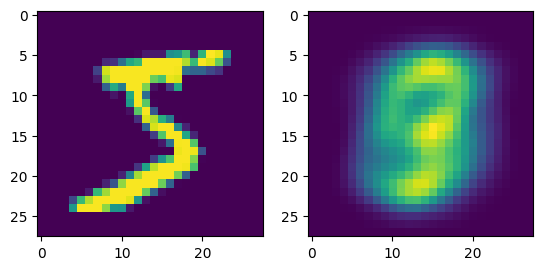

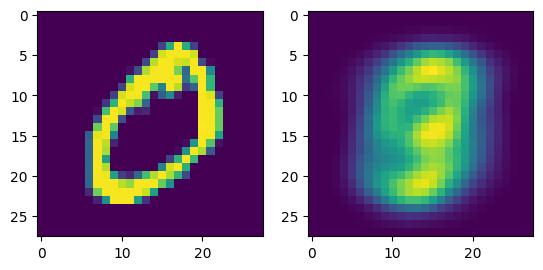

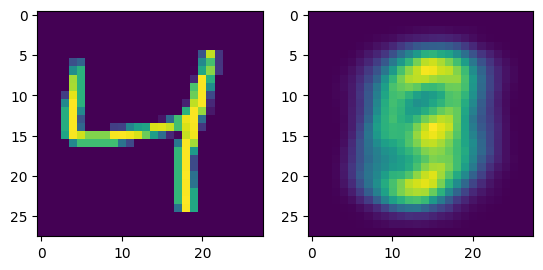

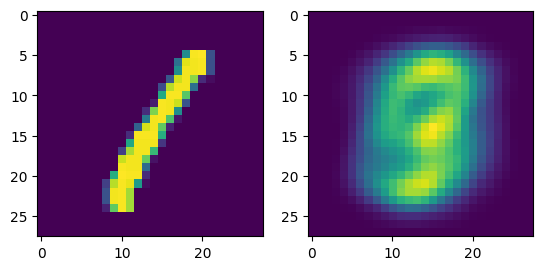

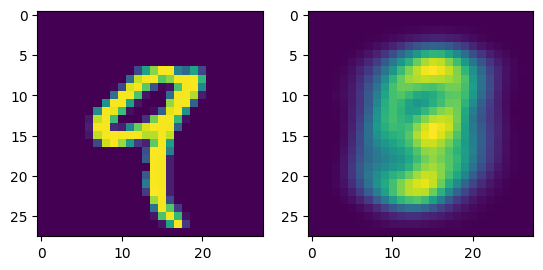

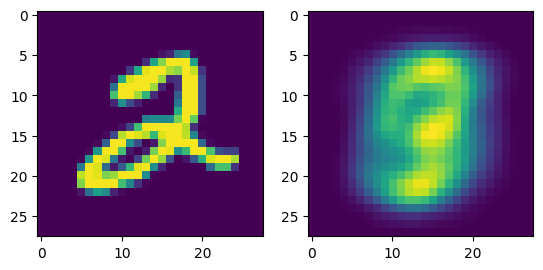

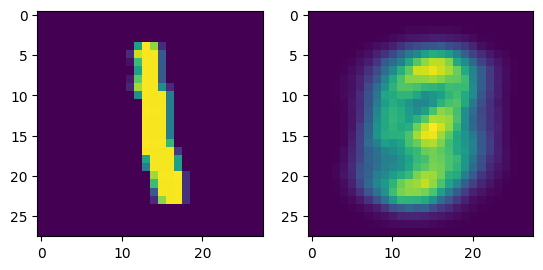

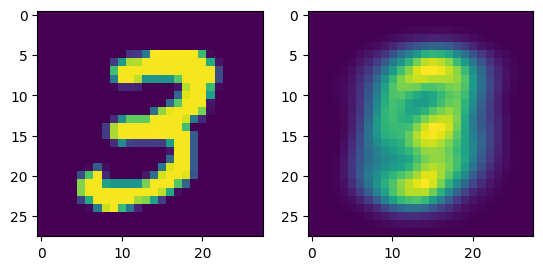

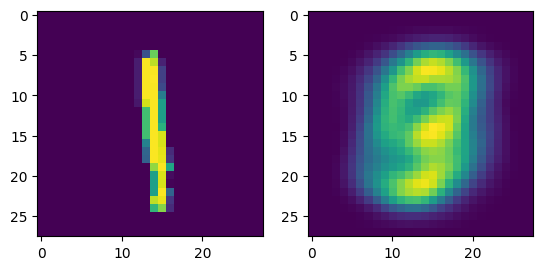

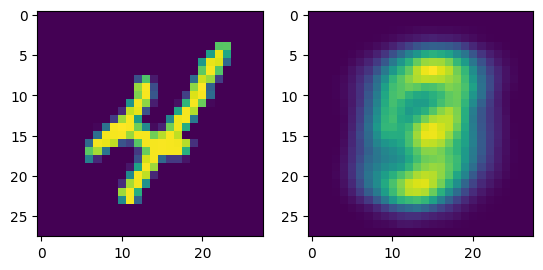

In [7]:
model.eval()
with torch.no_grad():
    for test_case_idx in tqdm(range(10)):
        valid_img, _ = trainset[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_img, _, _ = model(valid_img)        

        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[1].imshow(gen_img[0].cpu().permute(1, -1, 0).numpy())

100%|████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 35.67it/s]


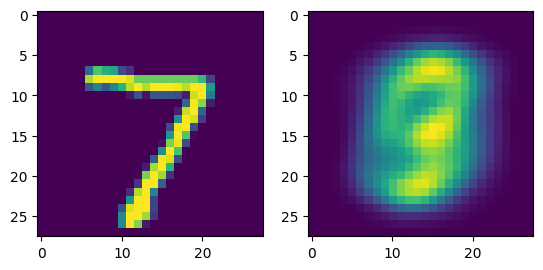

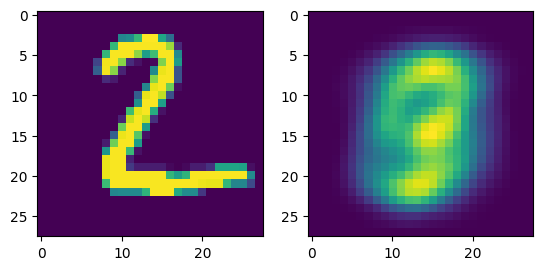

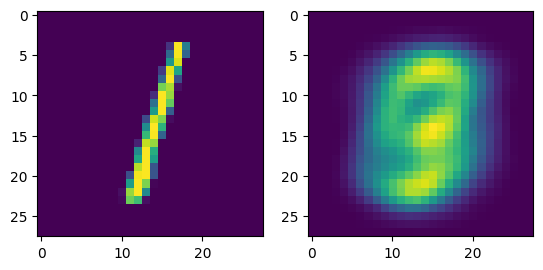

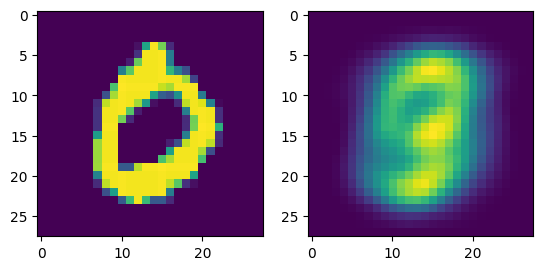

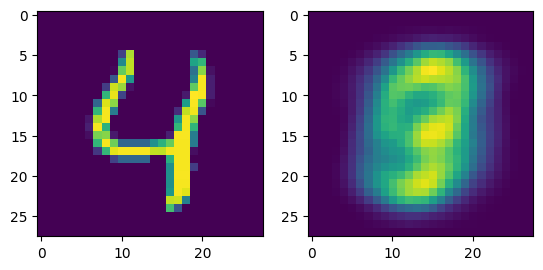

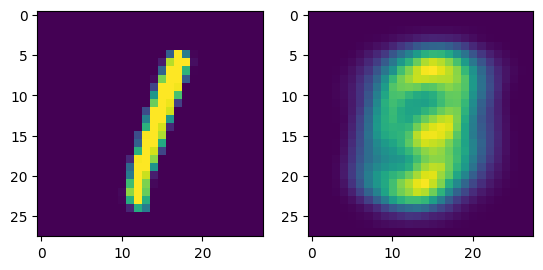

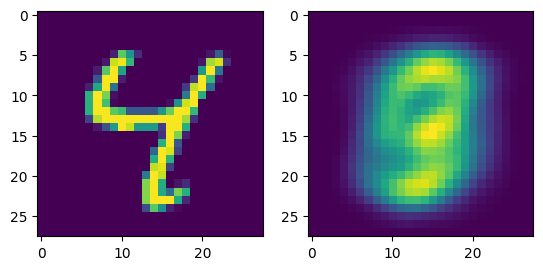

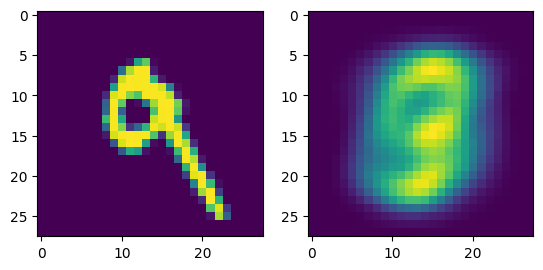

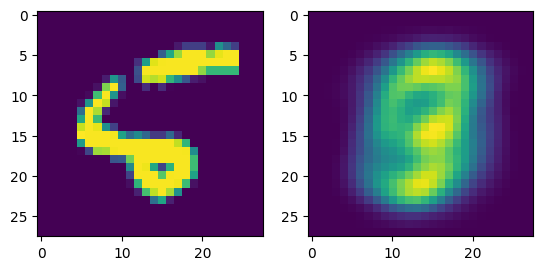

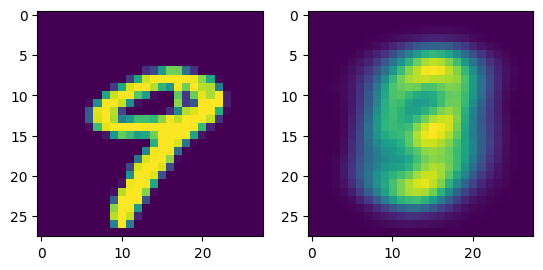

In [8]:
model.eval()
with torch.no_grad():
    for test_case_idx in tqdm(range(10)):
        valid_img, _ = testset[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_img, _, _ = model(valid_img)        

        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[1].imshow(gen_img[0].cpu().permute(1, -1, 0).numpy())

100%|███████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 107.99it/s]


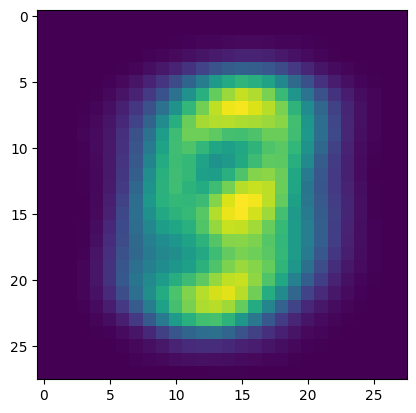

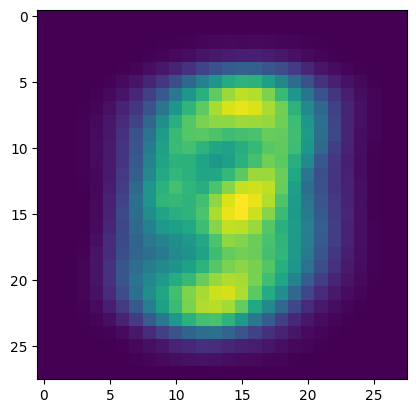

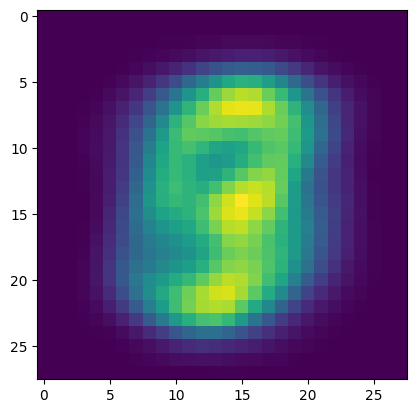

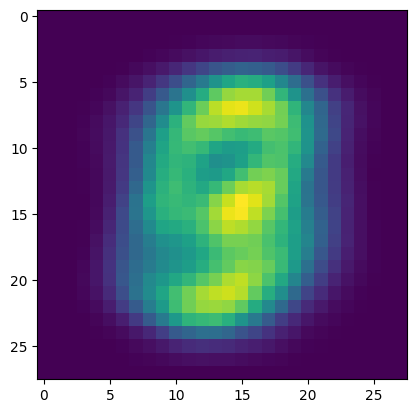

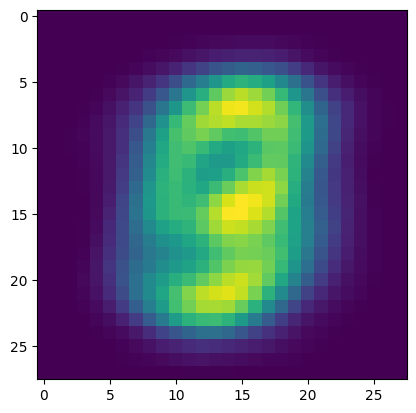

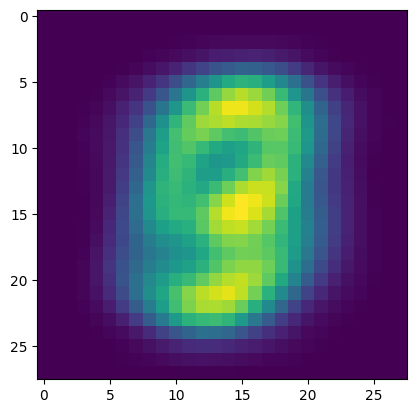

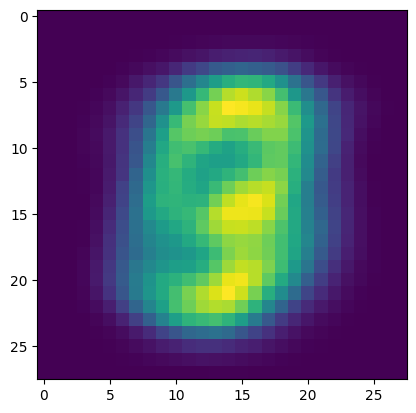

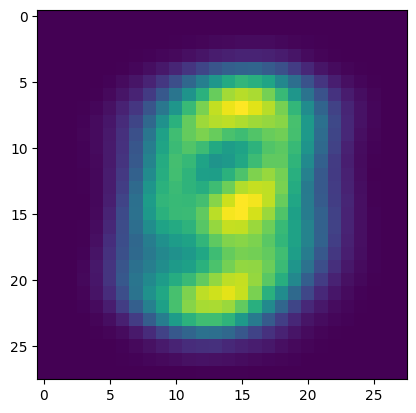

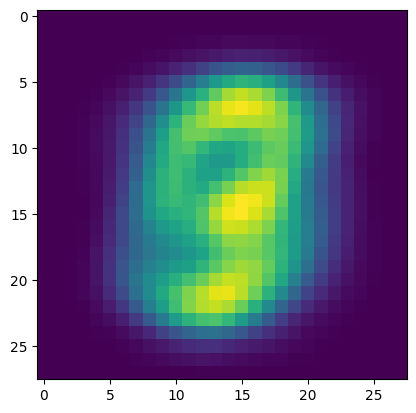

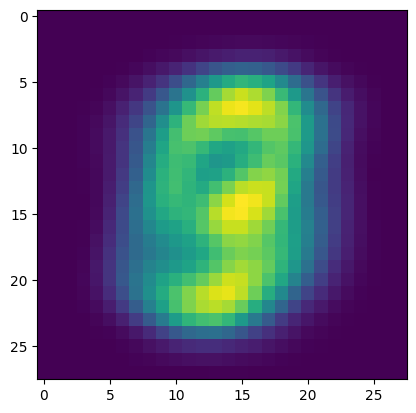

In [11]:
model.eval()
with torch.no_grad():
    for test_case_idx in tqdm(range(10)):
        # valid_img, _ = trainset[test_case_idx]
        # valid_img = valid_img.unsqueeze(dim=0).to(device)

        sample_z = torch.randn(1, 3).to(device)

        gen_img = model.decoder(sample_z)        

        plt.figure()
        plt.imshow(gen_img[0].cpu().permute(1, -1, 0).numpy())